In [1]:
import os

print("Current working directory:")
print(os.getcwd())

print("\nContents of current directory:")
print(os.listdir("."))

print("\nChecking ravdess_audio exists:")
print(os.path.isdir("ravdess_audio"))


Current working directory:
C:\Users\Lenovo\Downloads\Diarize

Contents of current directory:
['.ipynb_checkpoints', 'Audio_Speech_Actors_01-24 (1).zip', 'data', 'Noise_reduction.ipynb', 'pretrained_models', 'ravdess_audio', 'Untitled.ipynb', 'voice_classification']

Checking ravdess_audio exists:
True


In [2]:
count = 0
for root, _, files in os.walk("ravdess_audio"):
    count += len([f for f in files if f.lower().endswith(".wav")])

print("Total audio files:", count)


Total audio files: 1440


In [3]:
import sys
print(sys.executable)
print(sys.version)


C:\Users\Lenovo\anaconda3\envs\voice310\python.exe
3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]


In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import audmetric
import plotly.express as px


In [5]:
DATASET_PATH = "ravdess_audio"

count = 0
for root, _, files in os.walk(DATASET_PATH):
    count += len([f for f in files if f.endswith(".wav")])

print("Total audio files:", count)


Total audio files: 1440


In [6]:
def load_ravdess_data(path):
    files = []
    labels = []

    for root, _, filenames in os.walk(path):
        for file in filenames:
            if file.endswith(".wav"):
                # RAVDESS emotion code is the 3rd field
                emotion = int(file.split("-")[2])
                files.append(os.path.join(root, file))
                labels.append(emotion)

    return files, np.array(labels)

audio_files, labels = load_ravdess_data(DATASET_PATH)

print("Samples:", len(audio_files))
print("Emotion labels:", sorted(set(labels)))


Samples: 1440
Emotion labels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]


In [7]:
def extract_mfcc(filepath):
    y, sr = librosa.load(filepath, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfcc.T, axis=0)

X = np.array([
    extract_mfcc(f) for f in tqdm(audio_files, desc="Extracting MFCC")
])

y = labels

print("Feature shape:", X.shape)


Extracting MFCC: 100%|█████████████████████████████████████████████████████████████| 1440/1440 [00:53<00:00, 26.88it/s]

Feature shape: (1440, 13)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(1152, 13) (288, 13)


In [9]:
model = SVC(kernel="rbf", probability=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)


In [11]:
from sklearn.metrics import roc_curve


In [12]:
def compute_eer(y_true, y_score):
    """
    y_true: true labels (binary or multiclass binarized)
    y_score: predicted probabilities
    """
    eers = []

    for i in range(y_score.shape[1]):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_score[:, i])
        fnr = 1 - tpr
        eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
        eers.append(eer)

    return np.mean(eers)


In [14]:
from sklearn.metrics import roc_curve

def compute_eer_safe(y_true, y_score):
    """
    Robust multiclass EER computation.
    Skips classes with no positive or no negative samples.
    """
    eers = []

    n_classes = y_score.shape[1]

    for i in range(n_classes):
        # Binary ground truth for class i
        y_true_bin = (y_true == i)

        # Skip if class not present or all present
        if y_true_bin.sum() == 0 or y_true_bin.sum() == len(y_true_bin):
            continue

        fpr, tpr, _ = roc_curve(y_true_bin.astype(int), y_score[:, i])

        fnr = 1 - tpr

        # Guard against NaNs
        diff = np.abs(fnr - fpr)
        if np.all(np.isnan(diff)):
            continue

        eer = fpr[np.nanargmin(diff)]
        eers.append(eer)

    if len(eers) == 0:
        return np.nan

    return np.mean(eers)


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
model = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced"
)


In [20]:
accuracy = accuracy_score(y_test, y_pred)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test,
    y_pred,
    average="macro",
    zero_division=0
)

eer = compute_eer_safe(y_test, y_prob)

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "EER"],
    "Score": [accuracy, precision, recall, f1, eer]
})

metrics_df


,Metric,Score
0,Accuracy,0.281250
1,Precision,0.184577
2,Recall,0.264507
3,F1 Score,0.195680
4,EER,0.486749


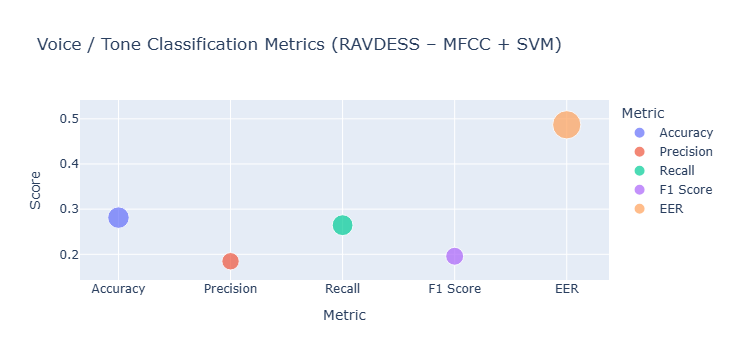

In [16]:
fig = px.scatter(
    metrics_df,
    x="Metric",
    y="Score",
    size="Score",
    color="Metric",
    title="Voice / Tone Classification Metrics (RAVDESS – MFCC + SVM)"
)

fig.show()


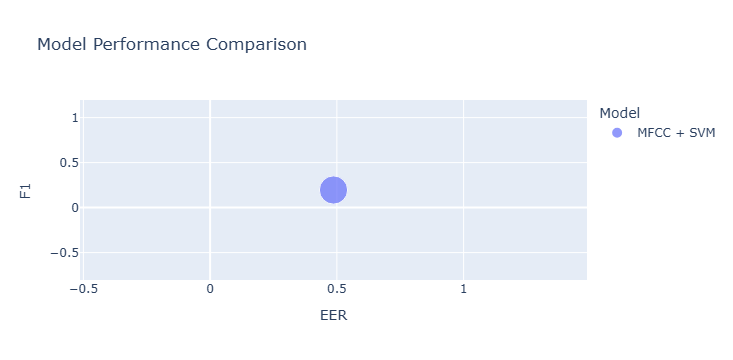

In [17]:
comparison_df = pd.DataFrame({
    "Model": ["MFCC + SVM"],
    "Accuracy": [accuracy],
    "F1": [f1],
    "EER": [eer]
})

fig = px.scatter(
    comparison_df,
    x="EER",
    y="F1",
    size="Accuracy",
    color="Model",
    title="Model Performance Comparison"
)

fig.show()


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [22]:
from sklearn.metrics import roc_curve
import numpy as np

def compute_eer_safe(y_true, y_score):
    eers = []

    n_classes = y_score.shape[1]

    for i in range(n_classes):
        y_true_bin = (y_true == i)

        # Skip invalid classes
        if y_true_bin.sum() == 0 or y_true_bin.sum() == len(y_true_bin):
            continue

        fpr, tpr, _ = roc_curve(y_true_bin.astype(int), y_score[:, i])
        fnr = 1 - tpr

        diff = np.abs(fnr - fpr)
        if np.all(np.isnan(diff)):
            continue

        eers.append(fpr[np.nanargmin(diff)])

    return np.mean(eers) if len(eers) > 0 else np.nan


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def train_and_evaluate(X, y, scale=False, balance=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    model = SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced" if balance else None
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    eer = compute_eer_safe(y_test, y_prob)

    return acc, prec, rec, f1, eer


In [24]:
results = []

configs = [
    ("M1: MFCC", False, False),
    ("M2: MFCC + Scaling", True, False),
    ("M3: MFCC + Scaling + Balanced", True, True)
]

for name, scale, balance in configs:
    acc, prec, rec, f1, eer = train_and_evaluate(X, y, scale, balance)
    results.append([name, acc, prec, rec, f1, eer])

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "EER"]
)

results_df


,Model,Accuracy,Precision,Recall,F1,EER
0,M1: MFCC,0.281250,0.184577,0.264507,0.195680,0.487278
1,M2: MFCC + Scaling,0.458333,0.452454,0.432945,0.420922,0.531501
2,M3: MFCC + Scaling + Balanced,0.437500,0.468045,0.462635,0.436737,0.531997


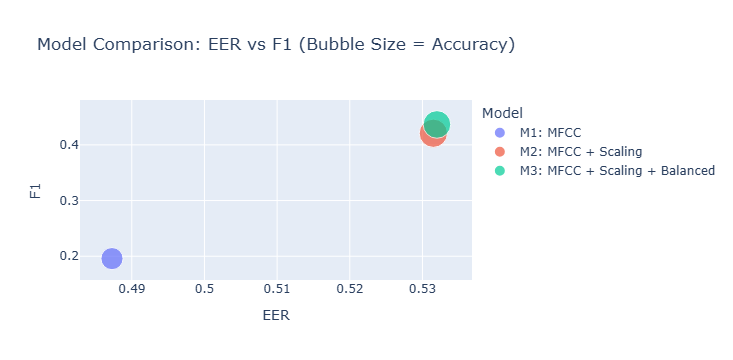

In [25]:
import plotly.express as px

fig = px.scatter(
    results_df,
    x="EER",
    y="F1",
    size="Accuracy",
    color="Model",
    title="Model Comparison: EER vs F1 (Bubble Size = Accuracy)",
    hover_data=["Accuracy", "Precision", "Recall"]
)

fig.show()


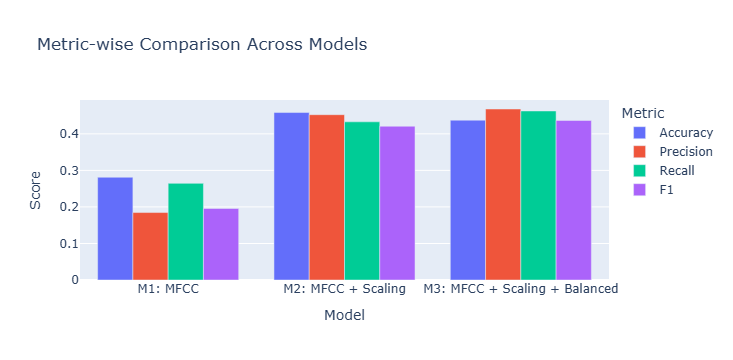

In [26]:
melted = results_df.melt(
    id_vars="Model",
    value_vars=["Accuracy", "Precision", "Recall", "F1"],
    var_name="Metric",
    value_name="Score"
)

fig = px.bar(
    melted,
    x="Model",
    y="Score",
    color="Metric",
    barmode="group",
    title="Metric-wise Comparison Across Models"
)

fig.show()


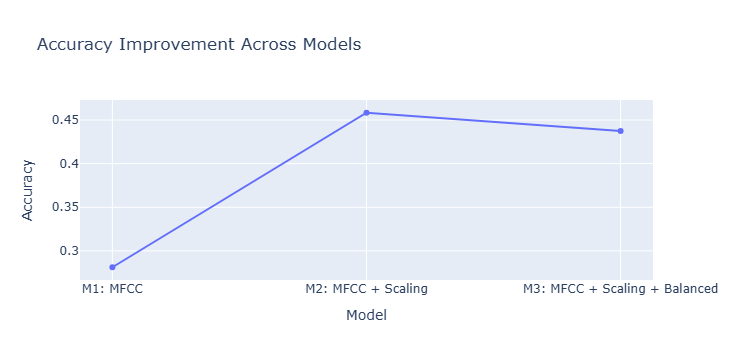

In [27]:
fig = px.line(
    results_df,
    x="Model",
    y="Accuracy",
    markers=True,
    title="Accuracy Improvement Across Models"
)

fig.show()


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------- ----------- 5.8/8.1 MB 27.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 25.2 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 16.5 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   -------------------------------- ------- 5.8/7.0 MB 29.4 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 25.4 MB/s  0:00:00
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   -

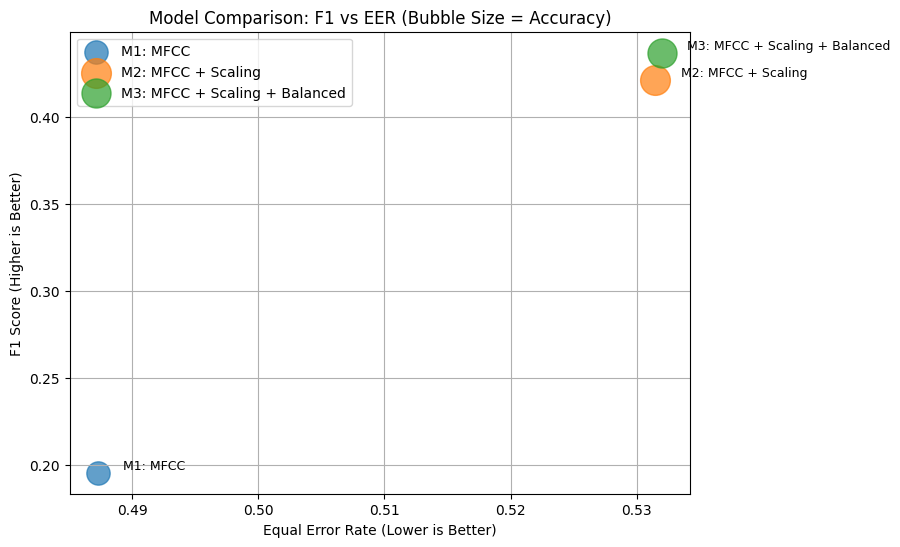

In [31]:
!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for _, row in results_df.iterrows():
    plt.scatter(
        row["EER"],
        row["F1"],
        s=row["Accuracy"] * 1000,   # scale bubble size
        label=row["Model"],
        alpha=0.7
    )
    plt.text(
        row["EER"] + 0.002,
        row["F1"] + 0.002,
        row["Model"],
        fontsize=9
    )

plt.xlabel("Equal Error Rate (Lower is Better)")
plt.ylabel("F1 Score (Higher is Better)")
plt.title("Model Comparison: F1 vs EER (Bubble Size = Accuracy)")
plt.grid(True)
plt.legend()
plt.show()


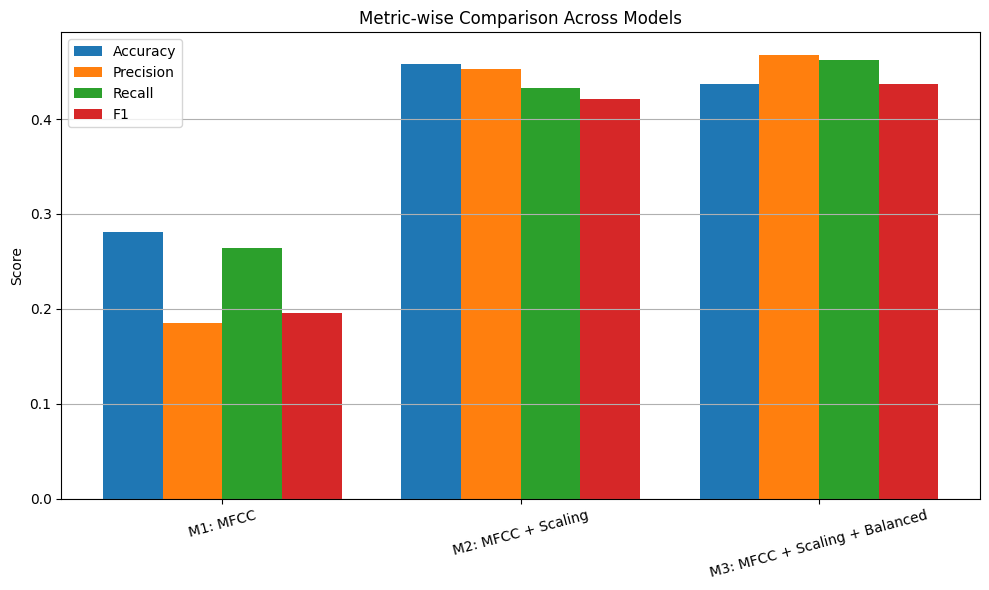

In [32]:
import numpy as np

metrics = ["Accuracy", "Precision", "Recall", "F1"]
models = results_df["Model"].values

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(
        x + i * width,
        results_df[metric],
        width,
        label=metric
    )

plt.xticks(x + width * 1.5, models, rotation=15)
plt.ylabel("Score")
plt.title("Metric-wise Comparison Across Models")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()


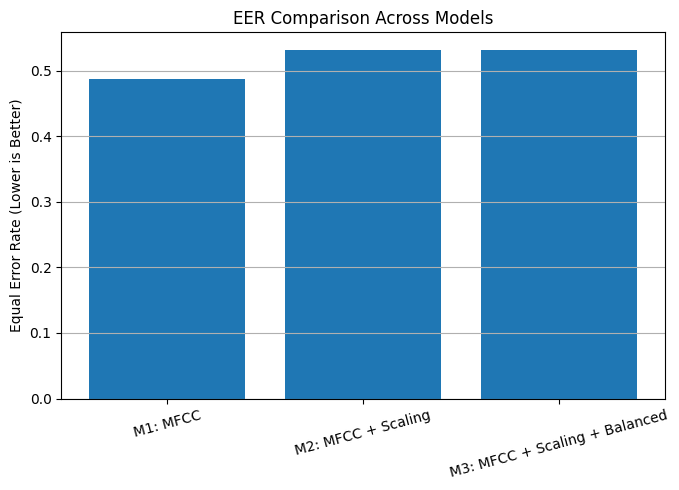

In [33]:
plt.figure(figsize=(7, 5))

plt.bar(
    results_df["Model"],
    results_df["EER"]
)

plt.ylabel("Equal Error Rate (Lower is Better)")
plt.title("EER Comparison Across Models")
plt.grid(axis="y")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
